<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/ChangHyun/prototype_model/train_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 환경 설정

필요한 패키지 불러오기

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install konlpy

matplotlib 한글 깨짐 해결

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

mecab 설치

In [ ]:
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

#### 해당 [사이트](https://teddylee777.github.io/colab/colab-korean)를 참고하여 위의 코드를 실행한 다음 런타임 재시작을 해주어야 합니다.

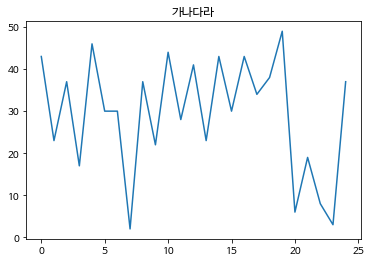

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.plot(np.random.randint(1, 50, 25))
plt.title("가나다라")
plt.show()

#### TPU 설정 코드

In [ ]:
# TPU 작동을 위한 코드
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

#### 구글 드라이브와 코랩 연결

In [66]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun/prototype_model')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
ls

baseline_KLUE_BERT.ipynb     bpe_10000.tmp              연습장.ipynb
baseline_KLUE_RoBERTa.ipynb  bpe_10000_train_spm.model  model/
baseline_KoELECTRA.ipynb     bpe_10000_train_spm.vocab  pred_data/
baseline_KoGPT.ipynb         data/                      submission/
baseline_LSTM.ipynb          eval_dataset/              train_baseline.ipynb


## 모델 클래스 및 함수 

#### 데이터 로딩 클래스

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

class DataLoad():


  def __init__(self, data_path):
    self.dataset = pd.read_csv(data_path)


  def split(self, split_size):
    X = self.dataset["pre_conversation"]
    Y = self.dataset["class"]
    print(self.dataset.groupby("class").count().iloc[:,0])
    print(self.dataset.head())
    # 전체 데이터의 split_size 비율 만큼은 테스트, 검증 데이터입니다.
    x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = split_size, 
                                                            random_state = 200,
                                                            stratify = Y)
    # 테스트, 검증 데이터의 개수는 1:1의 비율을 가집니다.
    x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
    print(f"x_train 개수 : {len(x_train)}")
    print(f"y_train 개수 : {len(y_train)}")
    print(f"x_val 개수 : {len(x_val)}")
    print(f"y_val 개수 : {len(y_val)}")
    print(f"x_test 개수 : {len(x_test)}")
    print(f"y_test 개수 : {len(y_test)}")
    print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
    print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
    print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")
    return x_train.tolist(), x_val.tolist(), x_test.tolist(), y_train.tolist(), y_val.tolist(), y_test.tolist()

#### 데이터 증강 클래스

In [64]:
import random
import gensim
from konlpy.tag import Mecab
from tqdm import tqdm

class DataAugmentation:


  def __init__(self, X, Y, word2vec_path):
    self.mecab = Mecab()
    self.word2vec = gensim.models.Word2Vec.load(word2vec_path)
    self.X = X
    self.Y = Y
  
  def sub_rep(self, X, sub_ratio = 0.1):
    # 전체 단어중에서 sub_ratio 만큼만 무작위 선택합니다.
    nouns = list(set(self.mecab.morphs(X)))
    sub_num = int(len(nouns) * sub_ratio)
    sub_list = random.sample(nouns, sub_num)

    # 대체 시킬 단어와 유사한 단어들을 불러옵니다.
    result = []
    for sub in sub_list:
      try:
        result.append((sub, self.word2vec.wv.most_similar(sub)[0]))
      except KeyError:
        pass
    result = list(map(lambda x: (x[0], x[1][0]), result))

    # 무작위 선택된 단어들을 유사한 단어들로 바꿔줍니다.
    for before, after in result:
      X = X.replace(before, after, 1)
    return X

  def sub_rep_dataset(self, sub_ratio = 0.1):
    # 입력 X에 sub_rep 함수 적용합니다.
    new_x = list(tqdm(map(lambda x: self.sub_rep(x, sub_ratio), self.X)))
    # 입력 Y의 값을 복사합니다.
    new_y = self.Y.copy()

    print("훈련 데이터 유의어 대체 증강 완료")
    print(f"증강시킨 데이터 개수 : {len(new_x)}")
    print(f"----데이터 증강 전 데이터 예시 ----\n{self.X[0]}")
    print(f"----데이터 증강 후 데이터 예시 ----\n{new_x[0]}")
    return new_x, new_y

  def label_repeat(self, label_id, num = 1):
    # 특정 레이블 label_id를 num 횟수 만큼 반복
    new_x = []
    new_y = []
    for i in range(num):
      label_index = (np.array(self.Y) == label_id)
      new_x += np.array(self.X)[label_index].tolist()
      new_y += np.array(self.Y)[label_index].tolist()
    
    print("훈련 데이터 특정 레이블 반복 증강 완료")
    print(f"반복되는 레이블 id : {label_id}")
    print(f"반복된 횟수 : {num}")
    return new_x, new_y

#### 기타 함수 

In [6]:
def id2label(x):
  # id에 맞는 실제 클래스로 변환시킵니다.
  if x == 0:
    return "협박 대화"
  elif x == 1:
    return "갈취 대화"
  elif x == 2:
    return "직장 내 괴롭힘 대화"
  elif x == 3:
    return "기타 괴롭힘 대화"
  elif x == 4:
    return "일반 대화"


def clf_score(y_test, y_pred):
  # 테스트 데이터에서 오분류된 데이터들의 idx를 리스트 타입으로 반환합니다.
  # classification report 
  false_list = [idx for idx, i in enumerate(y_test) if y_pred[idx] != i]
  print(f"모델이 틀린 데이터 개수 {len(false_list)}개")
  print(classification_report(y_test, y_pred))

  # confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
  conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
  sns.heatmap(conf_matrix, annot = True, fmt = "d")
  plt.title("Confusion Matrix")
  plt.xlabel("pred")
  plt.ylabel("true")
  plt.show()
  return false_list


def evaluate_result(score_list, x_test, y_pred, y_test):
  # 입력, 예측값, 실제값, 레이블별 score로 이루어진 판다스 데이터셋을 반환합니다.
  score_dataset = pd.DataFrame(score_list).add_prefix("label_")
  label_dataset = pd.DataFrame({"x_test":x_test, "y_pred":y_pred, "y_test":y_test})
  test_dataset = pd.concat([label_dataset, score_dataset], axis = 1)
  return test_dataset


def false_case_dataset(false_list, x_test, y_test, y_pred, print_example = False):
  # 오분류된 idx에 맞는 입력, 예측값, 실제값을 담은 리스트를 반환합니다.
  false_x_test = [x_test[i] for i in false_list]
  false_y_test = [y_test[i] for i in false_list]
  false_y_pred = [y_pred[i] for i in false_list]

  # 앞서 담은 리스트들을 판다스 데이터프레임 타입으로 변환시킵니다.
  false_dataset = pd.DataFrame({"text":false_x_test, "y_true":false_y_test, "y_pred":false_y_pred})
  # 숫자로된 id를 실제 레이블로 바꾸며 예시는 '0 -> 협박 대화' 입니다.
  false_dataset["y_true"] = false_dataset["y_true"].apply(lambda x : id2label(x))
  false_dataset["y_pred"] = false_dataset["y_pred"].apply(lambda x : id2label(x))

  # 오분류 예제의 내용을 보고 싶으면 print_example argument를 True로 바꿉니다.
  if print_example:
    for i in range(len(false_dataset)):
      sentence, prediction, real =false_dataset.iloc[i, :]
      print(f"예측 분류 : {prediction}")
      print(f"실제 분류 : {real}")
      print(sentence)
      print("\n")
  return false_dataset  


def save_csv(df, path, name):
  try:
    os.mkdir(path)
  except:
    pass
  new_path = os.path.join(path, name)
  df.to_csv(new_path)

#### Huggingface 모델 파이프라인 클래스

In [ ]:
import os
import re
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModel


class TFGPT2ForSequenceClassification(tf.keras.Model):
  """
  GPT모델은 따로 출력층에 softmax 레이어를 추가해야 합니다.
  """
  def __init__(self, model_name, num_labels):
      super(TFGPT2ForSequenceClassification, self).__init__()
      self.gpt = TFAutoModel.from_pretrained(model_name, 
                                              from_pt=True)
      self.classifier = tf.keras.layers.Dense(num_labels,
                                              kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                              activation='softmax',
                                              name='classifier')

  def call(self, inputs):
      outputs = self.gpt(input_ids=inputs)
      cls_token = outputs[0][:, -1]
      prediction = self.classifier(cls_token)

      return prediction


class TrainPipeline:
  def __init__(self, model_path, num_labels, batch_size = 16, epochs = 1):
    """
    Args:
      - model_path : Hugginface에서 사전학습된 모델들의 주소 str값을 받습니다.
      - num_labels : 분류되는 클래스의 개수 int값을 받습니다.
      - batch_size : 배치마다 들어가는 데이터의 개수 int값을 받습니다.
      - epochs : 모델이 학습하는 에폭 수 int값을 받습니다.
    Desc:
      - 데이터셋 구축, 모델 훈련, 저장, 검증의 과정을 거치는 훈련 파이프라인
    """
    self.model_path = model_path
    self.batch_size = batch_size
    self.epochs = epochs
    self.num_labels = num_labels
    self.tokenizer = AutoTokenizer.from_pretrained(self.model_path,
                                                   bos_token='</s>', 
                                                   eos_token='</s>', 
                                                   pad_token='<pad>')
    self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_path,
                                                                      num_labels = self.num_labels,
                                                                      from_pt=True)

  def dataset(self, X, Y, lstm = False):
    """
    Args:
      - X : 모델의 입력 변수로 str문장들로 구성된 list를 받습니다.
      - Y : 모델의 출력 변수로 id값으로 구성된 list를 받습니다.
      - lstm : lstm모델 여부를 결정하는 arg로 boolean을 받습니다.
    Desc:
      - 모델 학습에 들어가기 직전의 데이터셋으로 변환시켜주는 메소드입니다.
    Returns:
      - 모델이 GPT이면 (2D-array, 1D-array) 형태의 튜플을 반환합니다.
      - 모델이 BERT, LSTM이면 텐서플로우 데이터셋을 반환합니다.
    """
    # GPT 모델인 경우 넘파이로 반환시킵니다.
    if "GPT" in str(self.model):
      # 입력 변수 X의 원소에 차례대로 토큰화를 시키고 list에 넣습니다.
      input_ids, data_labels = [], []
      for example, label in tqdm(zip(X, Y), total=len(X)):
          bos_token = [self.tokenizer.bos_token]
          eos_token = [self.tokenizer.eos_token]
          tokens = bos_token + self.tokenizer.tokenize(example) + eos_token
          input_id = self.tokenizer.convert_tokens_to_ids(tokens)
          input_ids.append(input_id)
          data_labels.append(label)

      # X에 토큰화된 문장중에서 가장 긴 문장을 기준으로 패딩을 해줍니다.
      max_seq_len = max(map(lambda x : len(x), input_ids))
      input_ids = pad_sequences(input_ids, maxlen = max_seq_len, 
                                value = self.tokenizer.pad_token_id, 
                                padding='post')
      data_labels = np.array(data_labels)
      return input_ids, data_labels

    # BERT 모델인 경우 텐서플로우 데이터셋으로 반환시킵니다.
    if not lstm:
      encodings = self.tokenizer(X, truncation = True, padding = True)
      dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), 
                                                          Y))
      dataset = dataset.shuffle(1000).batch(self.batch_size)

    # LSTM 모델인 경우 텐서플로우 데이터셋으로 반환시킵니다.
    else:
      encodings = X
      dataset = tf.data.Dataset.from_tensor_slices((encodings, 
                                                    Y))
      dataset = dataset.shuffle(1000).batch(self.batch_size)
    return dataset    

  def training_dataset(self, train_dataset, val_dataset):
    """
    Args:
      - train_dataset : dataset 메소드를 거친 훈련 데이터셋을 받습니다.
      - val_dataset : dataset 메소드를 거친 검증 데이터셋을 받습니다.
    Desc:
      - 호출시킨 모델에 맞게 학습을 시키고 학습된 모델을 반환시켜줍니다.
    Returns:
      - 모델이 GPT면 학습된 subclass 모델을 반환합니다
      - 모델이 LSTM, BERT이면 학습된 functional 모델을 반환합니다.
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    losses = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

    # 모델이 GPT인 경우 앞서 선언된 subclass 모델을 가져와서 학습시킵니다.
    if "GPT" in str(self.model):
      x_train, y_train = train_dataset
      x_val, y_val = val_dataset
      num_labels = int(max(y_train) + 1)
      self.model = TFGPT2ForSequenceClassification(self.model_path,
                                              num_labels = num_labels)
      self.model.compile(optimizer = optimizer,
                        loss = losses,
                        metrics = ['accuracy'])
      self.model.fit(x_train, y_train,
                    epochs = self.epochs,
                    batch_size = self.batch_size,
                    validation_data = (x_val, y_val))
      return self.model

    # 모델이 LSTM, BERT인 경우 바로 학습시킵니다.
    else:
      self.model.compile(optimizer = optimizer,
                        loss = losses,
                        metrics = ['accuracy'])
      self.model.fit(train_dataset,
                    epochs = self.epochs,
                    batch_size = self.batch_size,
                    validation_data = val_dataset)
      return self.model 

  def evaluate_model(self, x_test):
    """
    Args:
      - x_test : LSTM, GPT모델이면 2-D array의 테스트 데이터를 받습니다.
    Desc:
      - 학습된 모델에 x_test를 예측한 점수와 클래스를 반환합니다.
    Returns:
      - LSTM, GPT 모델이면 (예측 점수 list, 클래스 1D-array)인 튜플을 반환합니다.
      - BERT 모델인 경우 (예측 점수 list, 클래스 list)인 튜플을 반환합니다.
    """
    predicted_label_list = []
    predicted_score_list = []
    
    # 테스트 데이터를 예측하는 모델이 LSTM 또는 GPT인 경우
    if "Functional" in str(self.model) or "GPT" in str(self.model):
      predicted_score_list = self.model.predict(x_test)
      y_pred = np.argmax(predicted_score_list, axis = -1)
      predicted_score_list = predicted_score_list.tolist()
    
    # 테스트 데이터를 예측하는 모델이 BERT인 경우
    else:
      clf_model = TextClassificationPipeline(
          tokenizer = self.tokenizer,
          model = self.model,
          framework = "tf",
          return_all_scores = True
          )
      for text in tqdm(x_test):
          preds_list = clf_model(text)[0]
          sorted_preds_list = max(preds_list, key=lambda x: x['score'])
          predicted_label_list.append(sorted_preds_list["label"]) # label
          predicted_score_list.append(list(map(lambda x : x['score'], preds_list))) # score
      y_pred = [int(label[-1]) for label in predicted_label_list]
    return predicted_score_list, y_pred
  
  def save_model_tokenizer(self, save_path):
    """
    Args:
      - save_path : 학습된 모델을 저장할 경로인 str를 받습니다.
    Desc:
      - save_path 경로에 폴더를 만들고 학습된 모델을 저장합니다.
    """

    # save_path에 맞는 새로운 경로를 만듭니다.
    try:
      os.mkdir(save_path)
    except:
      pass
    
    # 저장하는 모델이 GPT인 경우
    if "GPT" in str(self.model):
      folder_name = re.sub("/", "-", self.model_path)
      new_path = os.path.join(save_path, folder_name)
      self.model.save(new_path, save_format='tf')

    # 저장하는 모델이 LSTM인 경우
    elif "Functional" in str(self.model):
      new_path = os.path.join(save_path, "LSTM.h5", )
      self.model.save(new_path)
    
    # 저장하는 모델이 BERT인 경우
    else:
      folder_name = re.sub("/", "-", self.model_path)
      new_path = os.path.join(save_path, folder_name)    
      self.model.save_pretrained(new_path)
      self.tokenizer.save_pretrained(new_path)

#### LSTM 모델 파이프라인 클래스

In [53]:
import os
import re
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.layers import LSTM
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import sentencepiece as spm


class LSTMpipeline(TrainPipeline):
  def __init__(self, spm_path, vocab_size, batch_size = 16, epochs = 10):
    self.tokenizer = spm.SentencePieceProcessor()
    self.tokenizer.Load(spm_path)
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.epochs = epochs
    self.model = "LSTM"

  def tokenization(self, X, Y):
    # 불러온 sentencepiece 모델로 입력 데이터를 토큰화 시켜줍니다.
    token_x_train = [self.tokenizer.EncodeAsIds(x) for x in X]
    Y = np.array(Y).reshape(-1, 1)
    return token_x_train, Y

  def padding(self, X, max_len):
    # max_len에 맞게 입력 데이터를 패딩시켜줍니다.
    return pad_sequences(X, maxlen = max_len)
  
  def training_dataset(self, train_dataset, val_dataset, max_len):
    # LSTM의 입력층, 은닉층, 출력층을 설계합니다.
    inputs = tf.keras.layers.Input(shape = (max_len))
    layers = tf.keras.layers.Embedding(input_dim = self.vocab_size,
                                      output_dim = 128)(inputs)

    layers = tf.keras.layers.LSTM(64, return_sequences = True)(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)
    layers = tf.keras.layers.LSTM(64, return_sequences = True)(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)

    layers = tf.keras.layers.LSTM(128, return_sequences = True)(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)
    layers = tf.keras.layers.LSTM(128)(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)

    layers = tf.keras.layers.Dense(128, activation = "relu")(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)
    layers = tf.keras.layers.Dense(16, activation = "relu")(layers)
    outputs = tf.keras.layers.Dense(5, activation = "softmax")(layers)

    # 설계가 완료된 LSTM모델을 compile 시킵니다.
    self.model = tf.keras.Model(inputs, outputs)
    self.model.compile(optimizer="adam", 
                       loss="sparse_categorical_crossentropy", 
                       metrics=['accuracy'])

    # 텐서플로우의 함수형 API를 기반으로 LSTM 모델 학습시킵니다.
    callback_earlystop = EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
        patience=1)
    self.model.fit(train_dataset,
                   epochs = 10,
                   batch_size = self.batch_size,
                   validation_data = val_dataset,
                   callbacks = [callback_earlystop])    
    return self.model

## Main Huggingface 함수

2022/02/08/ test case
- "klue/bert-base", 
- "klue/roberta-base", 
- "monologg/koelectra-base-v3-discriminator"
- ["distilbert-base-multilingual-cased"](https://huggingface.co/distilbert-base-multilingual-cased)
- ["facebook/mbart-large-cc25"](https://huggingface.co/facebook/mbart-large-cc25) : seq2seq
- ["csebuetnlp/mT5_multilingual_XLSum"](https://huggingface.co/csebuetnlp/mT5_multilingual_XLSum) : seq2seq
- ["kykim/bert-kor-base"](https://huggingface.co/kykim/bert-kor-base)
- ["monologg/kobigbird-bert-base"](https://huggingface.co/monologg/kobigbird-bert-base) : embedding

2022/02/11 test case
- "skt/kogpt2-base-v2"

In [ ]:
# Huggingface에서 사용 가능한 사전학습 모델 리스트입니다.
model_paths = ["klue/bert-base",
               "skt/kogpt2-base-v2",
               "klue/roberta-base",
               "monologg/koelectra-base-v3-discriminator",
               "distilbert-base-multilingual-cased",
               "kykim/bert-kor-base"]          
# 변동 가능한 arguments로 save_path의 예시 : save_path = "./model/sample"
save_path = "./model/tmp" # 모델이 저장되는 위치
data_path = "./data/sample_data.csv" # 학습 데이터 위치
word2vec_path = "../packages/ko.bin" # 사전 학습 임베딩 벡터 저장 위치
batch_size = 8 # 모델에 들어가는 배치 크기
epochs = 1 # 에폭 수

for model_path in model_paths:
  print(f"{model_path} 파이프라인 시작")

  # 데이터 로딩
  load = DataLoad(data_path)
  x_train, x_val, x_test, y_train, y_val, y_test = load.split(0.1)
  test_text = x_test.copy()
  num_labels = int(max(y_train) + 1)

  # 데이터 증강
  data_aug = DataAugmentation(x_train, y_train, word2vec_path)
  # 데이터 증강 : 유의어 대체
  sub_rep_x, sub_rep_y = data_aug.sub_rep_dataset(sub_ratio = 0.1)
  # 데이터 증강 : 같은 레이블 반복
  repeat_x, repeat_y = data_aug.label_repeat(label_id = 3)
  # 증강된 데이터들 합치기
  x_train = x_train + sub_rep_x + sub_rep_x
  y_train = y_train + sub_rep_y + sub_rep_y

  # 데이터셋 구축
  pipeline = TrainPipeline(model_path, num_labels, batch_size, epochs)
  train_dataset = pipeline.dataset(x_train, y_train)
  val_dataset = pipeline.dataset(x_val, y_val)
  if "GPT" in str(pipeline.model):
    test_dataset = pipeline.dataset(x_test, y_test)
    x_test, y_test = test_dataset

  # 모델 학습, 예측, 저장
  model = pipeline.training_dataset(train_dataset, val_dataset)
  score_list, y_pred = pipeline.evaluate_model(x_test)
  pipeline.save_model_tokenizer(save_path)

  # 모델 검증
  false_list = clf_score(y_test, y_pred)
  false_dataset = false_case_dataset(false_list, test_text, y_test, y_pred)
  eval_dataset = evaluate_result(score_list, test_text, y_pred, y_test)
  save_dataset_path = os.path.join(save_path, "eval_result")
  model_name = model_path.split("/")[-1]
  save_csv(eval_dataset, save_dataset_path, f"{model_name}.csv")
  
  print(f"{model_path} 파이프라인 종료\n")

## Main LSTM 함수

class
0    896
1    896
2    896
3    896
4    896
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  ...                                   pre_conversation
0        3277  ...  야 니 롤 티어 첼린저더라 응 맞아 나 요즘 롤 즐겨하는데 티어가 안오르던데 너 좀...
1        2347  ...  빨리 돈 구해와 저 정말 돈 나올데가 없어요 제발요 니네 부모님 가게 정리한 돈 어...
2        2756  ...  당신 못배워먹은거 티내지마 냅둬 못배워먹어서 고작 이딴 일이나 하는거지 죄송합니다 ...
3        2461  ...  어제까지 완료 하기로 했던 일은 다 완료 되었나요 어제 급한 일이 있어서 처리를 못...
4        3369  ...  보육원 선생님 맞으시죠 선생님 저 은희예요 저 찾을 생각하지 마세요 안 돌아갈거니까...

[5 rows x 5 columns]
x_train 개수 : 4032
y_train 개수 : 4032
x_val 개수 : 224
y_val 개수 : 224
x_test 개수 : 224
y_test 개수 : 224
훈련 데이터 레이블 비율 확인 : Counter({3: 807, 4: 807, 1: 806, 0: 806, 2: 806})
검증 데이터 레이블 비율 확인 : Counter({0: 45, 2: 45, 3: 45, 1: 45, 4: 44})
테스트 데이터 레이블 비율 확인 : Counter({2: 45, 1: 45, 4: 45, 0: 45, 3: 44})


4032it [00:29, 136.16it/s]


훈련 데이터 유의어 대체 증강 완료
증강시킨 데이터 개수 : 4032
----데이터 증강 전 데이터 예시 ----
학생 잠깐 이리로 와봐 왜 그러시죠 요즘 부모들은 어린 애들한테도 명품 옷을 사준다고 하더니 진짜였군 제가 무슨 옷을 입든 무슨 상관이에요 학생들은 학생답게 다녀야지 그 재킷은 오늘부로 내 거다 싫어요 생일선물로 겨우 받은 옷이란 말이에요 일을 복잡하게 만드네 험한 꼴 당하고 싶어 아뇨 그치만 제가 정말 아끼는 옷인데 이번만 봐주시면 안될까요 좋아 그럼 인심 썼다 그 옷 대신 만원 가져와봐 엄마한테 문자할게요 잠시만요
----데이터 증강 후 데이터 예시 ----
학생 잠깐 이리로 와봐 왜 그러시가죠 요즘 부모들은 어린 애들한테도 명품 옷을 사준다고 하더니 가짜였군 제가 무슨 옷을 입든 무슨 상관이에요 학생들은 학생즐겁도록 다녀야지 그 재킷은 오늘부로 내 거다 힘들어요 생일선물로 겨우 받은 옷이란 말이에요 일을 복잡하게 만드네 험한 꼴 당하고 싶어 아뇨 그치만 제가 정말로 아끼는 옷인데 이번만 봐주시면 안될까요 좋아 도대체 인심 썼다 그 옷 대신 만원 가져와봐 엄마한테 문자할게요 잠시만요
훈련 데이터 특정 레이블 반복 증강 완료
반복되는 레이블 id : 3
반복된 횟수 : 1
Epoch 1/10
7/7 [==============================] - 7s 295ms/step - loss: 1.5325 - accuracy: 0.4500 - val_loss: 1.4381 - val_accuracy: 0.2900
Epoch 2/10
7/7 [==============================] - 1s 83ms/step - loss: 1.1930 - accuracy: 0.4500 - val_loss: 1.3037 - val_accuracy: 0.3600
Epoch 3/10
7/7 [==============================] - 1s 83ms/step - loss: 1.1438 - accuracy: 0.4600 - val_l

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


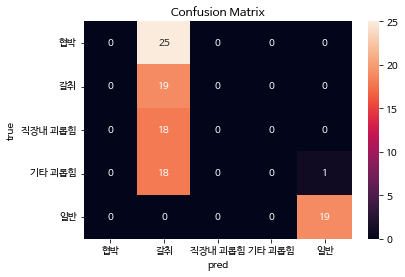

In [62]:
spm_path = "./bpe_10000_train_spm.model"
word2vec_path = "../packages/ko.bin"
batch_size = 16
vocab_size = 10000


# 데이터 로딩
load = DataLoad(data_path)
x_train, x_val, x_test, y_train, y_val, y_test = load.split(0.1)
num_labels = int(max(y_train) + 1)
test_text = x_test.copy()

# 데이터 증강
data_aug = DataAugmentation(x_train, y_train, word2vec_path)
# 데이터 증강 : 유의어 대체
sub_rep_x, sub_rep_y = data_aug.sub_rep_dataset(sub_ratio = 0.1)
# 데이터 증강 : 같은 레이블 반복
repeat_x, repeat_y = data_aug.label_repeat(label_id = 3)
# 증강된 데이터들 합치기
x_train = x_train + sub_rep_x + sub_rep_x
y_train = y_train + sub_rep_y + sub_rep_y

# 데이터셋 구축 : 토큰화
lstmpipline = LSTMpipeline(spm_path, vocab_size, epochs = 1)
x_train, y_train = lstmpipline.tokenization(x_train, y_train)
x_val, y_val = lstmpipline.tokenization(x_val, y_val)
x_test, y_test = lstmpipline.tokenization(x_test, y_test)
# 데이터셋 구축 : 패딩
max_length = max([max(map(lambda x : len(x), tmp)) for tmp in [x_train, x_val, x_test]])
x_train = lstmpipline.padding(x_train, max_length)
x_val = lstmpipline.padding(x_val, max_length)
x_test = lstmpipline.padding(x_test, max_length)
# 데이터셋 구축 : 넘파이 데이터셋
train_dataset = lstmpipline.dataset(x_train, y_train, lstm = True)
val_dataset = lstmpipline.dataset(x_val, y_val, lstm = True)

# LSTM 모델 학습
model = lstmpipline.training_dataset(train_dataset, val_dataset, max_length)
score_list, y_pred = lstmpipline.evaluate_model(x_test)
lstmpipline.save_model_tokenizer(save_path + "/LSTM")

# 모델 검증
false_list = clf_score(y_test, y_pred)
false_dataset = false_case_dataset(false_list, test_text, y_test, y_pred)
eval_dataset = evaluate_result(score_list, test_text, y_pred, y_test.reshape(-1))
save_dataset_path = os.path.join(save_path, "eval_result")
save_csv(eval_dataset, save_dataset_path, "LSTM.csv")

## 앙상블 Soft voting

In [28]:
import pandas as pd
from collections import defaultdict
from glob import glob

def load_result_df(save_path_2):
  csv_dic = defaultdict()
  path_list = glob(save_path_2 + "/eval_result/*")
  key_list = []
  for path in path_list:
    key = path.split("/")[-1]
    key_list.append(key)
    csv_dic[key] = pd.read_csv(path)
  csv_dic = dict(csv_dic)
  print(f"모델명 : {key_list}")
  print(f"변수명 : {list(csv_dic[key_list[0]].columns)}")
  return csv_dic, key_list


save_path = ["./model/tmp"]
csv_dic = dict()            

for path in save_path:
  dic, key_list = load_result_df(path)
  csv_dic.update(dic)
  key_list += key_list

모델명 : ['bert-base.csv', 'kogpt2-base-v2.csv']
변수명 : ['Unnamed: 0', 'x_test', 'y_pred', 'y_test', 'label_0', 'label_1', 'label_2', 'label_3', 'label_4']


In [29]:
from itertools import combinations

total_case = []
for i in range(1, len(key_list)+1):
  total_case = total_case + list(combinations(key_list, i))
total_case = list(map(list, total_case))
print(f"앙상블 경우의 수 : {len(total_case)}가지")

앙상블 경우의 수 : 15가지


#### Stacking(미완성)

In [ ]:
one_case = total_case[:4]
one_case = sum(one_case, [])
label_score_list = []
for key in one_case:
  label_score_list.append(csv_dic[key].iloc[:,-5:].to_numpy())
label_score_list = np.array(label_score_list)

In [ ]:
stack_input = label_score_list.reshape(-1, len(one_case), 5)
print(stack_input.shape)
stack_output = csv_dic["LSTM.csv"]["y_test"].to_numpy().reshape(-1,1)
print(stack_output.shape)

(224, 4, 5)
(224, 1)


In [ ]:
x_tr, x_te, y_tr, y_te = train_test_split(stack_input, stack_output, test_size=0.1)

In [ ]:
inputs0 = tf.keras.layers.Input(shape = (x_tr.shape[-1]))
inputs1 = tf.keras.layers.Input(shape = (x_tr.shape[-1]))
inputs2 = tf.keras.layers.Input(shape = (x_tr.shape[-1]))
inputs3 = tf.keras.layers.Input(shape = (x_tr.shape[-1]))

layers0 = tf.keras.layers.Dense(1)(inputs0)
layers1 = tf.keras.layers.Dense(1)(inputs1)
layers2 = tf.keras.layers.Dense(1)(inputs2)
layers3 = tf.keras.layers.Dense(1)(inputs3)

concat = tf.keras.layers.concatenate([layers0, layers1, layers2, layers3])
outputs = tf.keras.layers.Dense(5, activation = "softmax")(concat)

stack_model = tf.keras.Model([inputs0, inputs1, inputs2, inputs3], outputs)
stack_model.compile(optimizer = "adam",
                    loss = "sparse_categorical_crossentropy",
                    metrics = ["accuracy"])
stack_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_74 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 input_75 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 input_76 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 input_77 (InputLayer)          [(None, 5)]          0           []                               
                                                                                           

In [ ]:
tmp = [x_tr[:,i,:] for i in range(len(one_case))]
te_tmp = [x_te[:,i,:] for i in range(len(one_case))]
print(len(tmp), tmp[0].shape)
print(y_tr.shape)
stack_model.fit(tmp, y_tr, epochs = 1000, verbose=1,
                validation_data = (te_tmp, y_te),
                batch_size = 16)

4 (201, 5)
(201, 1)
Epoch 1/1000
13/13 [==============================] - 1s 14ms/step - loss: 1.6253 - accuracy: 0.2338 - val_loss: 1.6097 - val_accuracy: 0.1739
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.6133 - accuracy: 0.2488 - val_loss: 1.6165 - val_accuracy: 0.1739
Epoch 3/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.6047 - accuracy: 0.2537 - val_loss: 1.6266 - val_accuracy: 0.1739
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.5988 - accuracy: 0.2488 - val_loss: 1.6345 - val_accuracy: 0.1304
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.5916 - accuracy: 0.2587 - val_loss: 1.6419 - val_accuracy: 0.1304
Epoch 6/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.5875 - accuracy: 0.2637 - val_loss: 1.6489 - val_accuracy: 0.1304
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.5826 - accuracy: 0.2836 - val_loss: 1.6562 - val_ac

#### Soft voting

1번째 모델 경우의 수 : ['bert-base.csv']
모델이 틀린 데이터 개수 49개
              precision    recall  f1-score   support

           0       0.57      0.92      0.71        25
           1       1.00      0.05      0.10        19
           2       1.00      0.06      0.11        18
           3       0.44      0.37      0.40        19
           4       0.45      1.00      0.62        19

    accuracy                           0.51       100
   macro avg       0.69      0.48      0.39       100
weighted avg       0.68      0.51      0.41       100



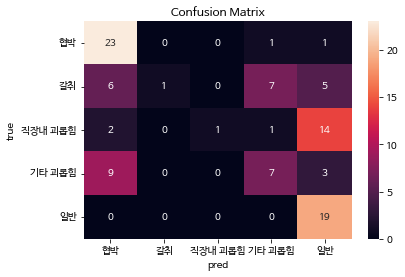

2번째 모델 경우의 수 : ['kogpt2-base-v2.csv']
모델이 틀린 데이터 개수 65개
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        18
           3       0.23      1.00      0.38        19
           4       1.00      0.84      0.91        19

    accuracy                           0.35       100
   macro avg       0.25      0.37      0.26       100
weighted avg       0.23      0.35      0.25       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


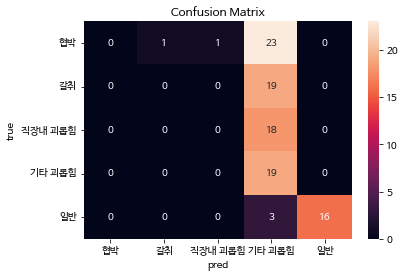

3번째 모델 경우의 수 : ['bert-base.csv']
모델이 틀린 데이터 개수 49개
              precision    recall  f1-score   support

           0       0.57      0.92      0.71        25
           1       1.00      0.05      0.10        19
           2       1.00      0.06      0.11        18
           3       0.44      0.37      0.40        19
           4       0.45      1.00      0.62        19

    accuracy                           0.51       100
   macro avg       0.69      0.48      0.39       100
weighted avg       0.68      0.51      0.41       100



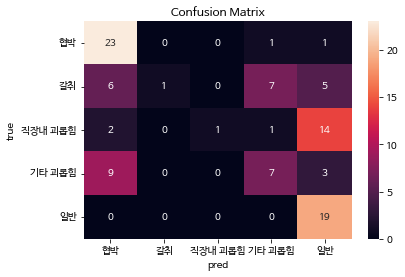

4번째 모델 경우의 수 : ['kogpt2-base-v2.csv']
모델이 틀린 데이터 개수 65개
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        18
           3       0.23      1.00      0.38        19
           4       1.00      0.84      0.91        19

    accuracy                           0.35       100
   macro avg       0.25      0.37      0.26       100
weighted avg       0.23      0.35      0.25       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


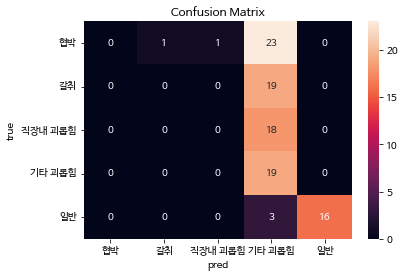

5번째 모델 경우의 수 : ['bert-base.csv', 'kogpt2-base-v2.csv']
모델이 틀린 데이터 개수 61개
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.50      0.05      0.10        19
           2       0.00      0.00      0.00        18
           3       0.24      0.95      0.39        19
           4       0.83      1.00      0.90        19

    accuracy                           0.39       100
   macro avg       0.51      0.41      0.29       100
weighted avg       0.55      0.39      0.28       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


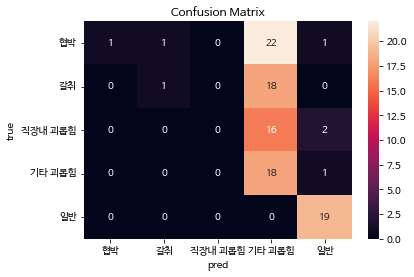

6번째 모델 경우의 수 : ['bert-base.csv', 'bert-base.csv']
모델이 틀린 데이터 개수 49개
              precision    recall  f1-score   support

           0       0.57      0.92      0.71        25
           1       1.00      0.05      0.10        19
           2       1.00      0.06      0.11        18
           3       0.44      0.37      0.40        19
           4       0.45      1.00      0.62        19

    accuracy                           0.51       100
   macro avg       0.69      0.48      0.39       100
weighted avg       0.68      0.51      0.41       100



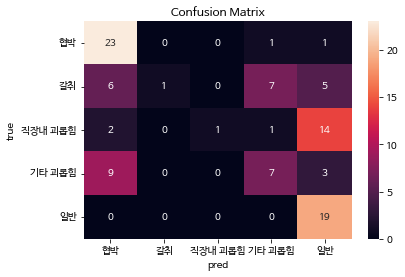

7번째 모델 경우의 수 : ['bert-base.csv', 'kogpt2-base-v2.csv']
모델이 틀린 데이터 개수 61개
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.50      0.05      0.10        19
           2       0.00      0.00      0.00        18
           3       0.24      0.95      0.39        19
           4       0.83      1.00      0.90        19

    accuracy                           0.39       100
   macro avg       0.51      0.41      0.29       100
weighted avg       0.55      0.39      0.28       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


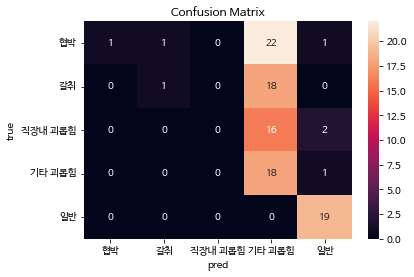

8번째 모델 경우의 수 : ['kogpt2-base-v2.csv', 'bert-base.csv']
모델이 틀린 데이터 개수 61개
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.50      0.05      0.10        19
           2       0.00      0.00      0.00        18
           3       0.24      0.95      0.39        19
           4       0.83      1.00      0.90        19

    accuracy                           0.39       100
   macro avg       0.51      0.41      0.29       100
weighted avg       0.55      0.39      0.28       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


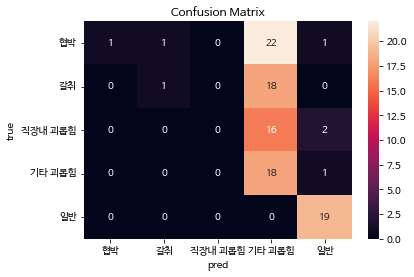

9번째 모델 경우의 수 : ['kogpt2-base-v2.csv', 'kogpt2-base-v2.csv']
모델이 틀린 데이터 개수 65개
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        18
           3       0.23      1.00      0.38        19
           4       1.00      0.84      0.91        19

    accuracy                           0.35       100
   macro avg       0.25      0.37      0.26       100
weighted avg       0.23      0.35      0.25       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


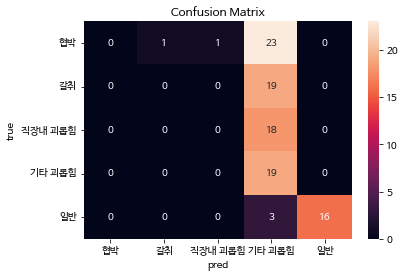

10번째 모델 경우의 수 : ['bert-base.csv', 'kogpt2-base-v2.csv']
모델이 틀린 데이터 개수 61개
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.50      0.05      0.10        19
           2       0.00      0.00      0.00        18
           3       0.24      0.95      0.39        19
           4       0.83      1.00      0.90        19

    accuracy                           0.39       100
   macro avg       0.51      0.41      0.29       100
weighted avg       0.55      0.39      0.28       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


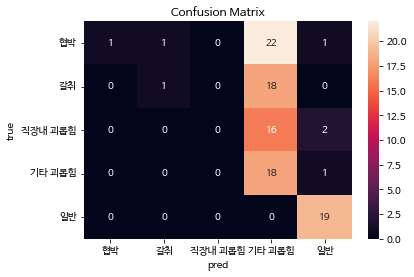

11번째 모델 경우의 수 : ['bert-base.csv', 'kogpt2-base-v2.csv', 'bert-base.csv']
모델이 틀린 데이터 개수 54개
              precision    recall  f1-score   support

           0       0.75      0.36      0.49        25
           1       0.00      0.00      0.00        19
           2       1.00      0.06      0.11        18
           3       0.32      0.89      0.47        19
           4       0.61      1.00      0.76        19

    accuracy                           0.46       100
   macro avg       0.54      0.46      0.36       100
weighted avg       0.54      0.46      0.37       100



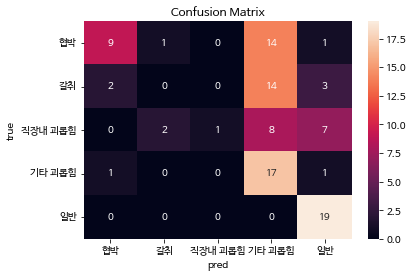

12번째 모델 경우의 수 : ['bert-base.csv', 'kogpt2-base-v2.csv', 'kogpt2-base-v2.csv']
모델이 틀린 데이터 개수 62개
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        18
           3       0.24      1.00      0.39        19
           4       1.00      1.00      1.00        19

    accuracy                           0.38       100
   macro avg       0.25      0.40      0.28       100
weighted avg       0.24      0.38      0.26       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


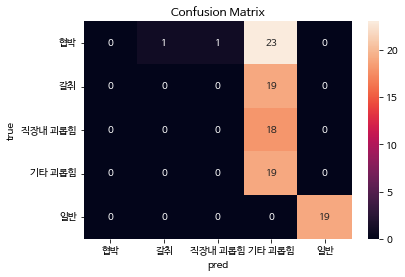

13번째 모델 경우의 수 : ['bert-base.csv', 'bert-base.csv', 'kogpt2-base-v2.csv']
모델이 틀린 데이터 개수 54개
              precision    recall  f1-score   support

           0       0.75      0.36      0.49        25
           1       0.00      0.00      0.00        19
           2       1.00      0.06      0.11        18
           3       0.32      0.89      0.47        19
           4       0.61      1.00      0.76        19

    accuracy                           0.46       100
   macro avg       0.54      0.46      0.36       100
weighted avg       0.54      0.46      0.37       100



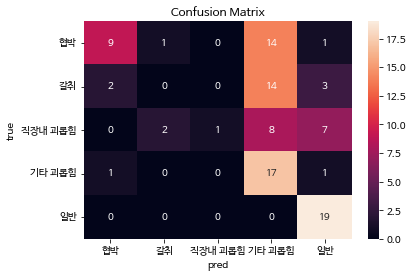

14번째 모델 경우의 수 : ['kogpt2-base-v2.csv', 'bert-base.csv', 'kogpt2-base-v2.csv']
모델이 틀린 데이터 개수 62개
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        18
           3       0.24      1.00      0.39        19
           4       1.00      1.00      1.00        19

    accuracy                           0.38       100
   macro avg       0.25      0.40      0.28       100
weighted avg       0.24      0.38      0.26       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


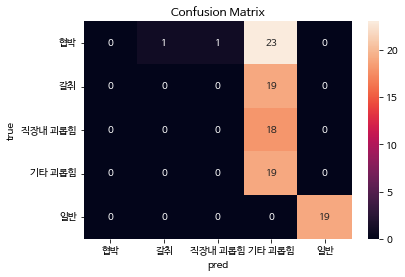

15번째 모델 경우의 수 : ['bert-base.csv', 'kogpt2-base-v2.csv', 'bert-base.csv', 'kogpt2-base-v2.csv']
모델이 틀린 데이터 개수 61개
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.50      0.05      0.10        19
           2       0.00      0.00      0.00        18
           3       0.24      0.95      0.39        19
           4       0.83      1.00      0.90        19

    accuracy                           0.39       100
   macro avg       0.51      0.41      0.29       100
weighted avg       0.55      0.39      0.28       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


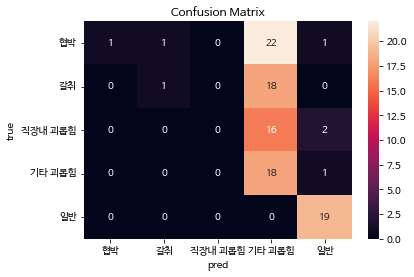

In [32]:
for idx, case in enumerate(total_case):
  # 레이블 별 평균 점수 산출
  label_score_list = []
  for key in case:
    label_score_list.append(csv_dic[key].iloc[:,-5:].to_numpy())
  label_score_list = np.array(label_score_list)


  score_average = np.average(label_score_list, axis = 0)
  soft_voting = np.argmax(score_average, axis = -1)

  # 정답값과 예측값을 구하며 서로 맞지 않는 경우의 수도 구함
  y_pred = soft_voting.tolist()
  y_test = csv_dic[key_list[0]]["y_test"].tolist()
  false_list = [idx for idx, i in enumerate(y_test) if y_pred[idx] != i]
  if len(false_list) <= 100:
    print(f"{idx+1}번째 모델 경우의 수 : {case}")
    clf_score(y_test, y_pred)

    # 잘못 예측한 케이스가 담긴 데이터셋
    x_test = csv_dic[key_list[0]]["x_test"]
    false_score_dataset = pd.DataFrame(score_average)
    false_score_dataset.add_prefix("label_")
    
    false_dataset = pd.DataFrame({"x_test":x_test, "y_pred":y_pred, "y_true":y_test})
    total_dataset = pd.concat([false_dataset, false_score_dataset], axis = 1)

    total_dataset = total_dataset.iloc[false_list, :]

In [ ]:
for i in range(len(false_dataset)):
  sentence, prediction, real =false_dataset.iloc[i, :]
  print(f"예측 분류 : {prediction}")
  print(f"실제 분류 : {real}")
  print(sentence)
  print("\n")

예측 분류 : 협박 대화
실제 분류 : 기타 괴롭힘 대화
이자는 이자까지 줬잖아 그건 저번 기간 이자고 이번 기간 이자까지 줘야지 이 년아 얼만데 너 하는 꼬라지 같아서 은 더 받아야겠는데 장난하지 말고 이자는 됐으니까 좀 맞자 저번에 잊었어 원금 다 갚은 대신 내 집에 들어오지 말고내 몸 털끝 하나도 건들지 말라고 난 동의한 적 없어 멍청한 년아 죽을때까지 너 따라다니면서 돈 뜯을 거야 너 사는 재미 없게 콱 죽어버려야겠다


예측 분류 : 협박 대화
실제 분류 : 갈취 대화
선생님 저 이번 시험 점수 도저히 납득이 되질 않습니다 은혜야 갑자기 그게 무슨 말이니 이미 성적처리는 다 끝났단다 제가 왜 과제 점수에서 이렇게 나온 거죠 그야 니가 요구하는 조건을 잘 충족시키지 못했으니 그렇게 나온거지 너 지금 내가 널 일부러 낮게 줬다는 거니 아뇨 그런 건 아니지만 선생님께서 저한테 이렇게 하시면 안 될 것 같아서요 은혜야 너 이거 좀 주제 넘는다고 생각안하니 평가는 너희가 하는게 아니라 선생인 내가 하는거야 쓸데 없는 소리하지말고 돌아가 아뇨 선생님 저 다 알고있어요 선생님이 혜정이 어머님께 뒷 돈 받으신거요 뭐 너 그게 무슨소리니 내가 그런 부당한 일을 저질렀다는 게 저 증거도 가지고 있구요 못 믿으시겠다면 제가 가진 증거 다 퍼트릴게요 교육청에 학교에 아이들에게요 너 정말 그게 지금 선생님한테 할 말이니 날 협박하는거야 선생님 그거 아시죠 나쁜 소문은 빨리퍼지고 아무리 거짓말이였다고해도 이미 늦은 뒤라는 거 그럼 전 제 성적 다시 정정해주실 거라 믿고 가볼게요


예측 분류 : 협박 대화
실제 분류 : 기타 괴롭힘 대화
야 분 뒤에 소각장으로 나와 왜 뭔 말이 많아 나오라면 나올 것이지 저기 그냥 여기서 말해주면 안될까 뭐 많이컸네 한마디만 더 하면 여기서 안끝난다 미안해 미안하면 나와 분 늦으면 한대다 알겠어


예측 분류 : 협박 대화
실제 분류 : 기타 괴롭힘 대화
아니 피뽑는게 왜이렇게아파 환자분 원래조끔 따금해요 바늘이 들어가는데 안아플수가없잖아요 

In [ ]:
false_dataset.to_excel("./오분류예제.xlsx")

## Submission 제출

In [ ]:
import json


test_path = "/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/data/TUNiB/test.json"
with open(test_path, "r", encoding = "utf-8") as st_json:
    test = json.load(st_json)

In [ ]:
def remove_punctuation(x):
  x = re.sub("[^ㄱ-ㅎ가-힣0-9]+", " ", x)
  x = re.sub("[ ]+", " ", x)
  x = x.strip()
  return x

test_set = pd.DataFrame()
test_set["text"] = pd.read_json(test_path).T["text"].apply(lambda x : remove_punctuation(x))

In [ ]:
k = 0
tmp = []
for i, j in zip(list(test_set.index), test_set["text"]):
  print(i, k, j)
  if int(i[2:]) != k:
    tmp += [(i,j)]
  k += 1

t_000 0 야 임마 돈을 빨리 갚아야 될것 아니야 죄송합니다 갑자기 돈이 필요하신 줄은 몰랐습니다 항상 준비를 해놔야 하는게 정상 아니냐 이 비정상아 아니 애초에 돈을 빌릴때 여유시간이 많이 있는걸로 알고 있었는데요 너 지금 나한테 대드냐 아 죄송합니다 아니 애초에 돈을 많이 안 가진 상태면 빌리지를 말아 새끼야 네 알겠습니다 아참 지금 돈 갚을 때 이자 이십오 퍼센트는 기본으로 하고 나한테 대든 죄야
t_001 1 너 지금 만나는 여자 내 여자친구 아니야 미안 어쩌다 보니 그렇게 됐다 좋은 걸 어떡하냐 넌 말이 참 쉽네 우리가 몇 년 친군데 네가 어떻게 나한테 그럴 수 있어 야 우리 수진이도 내가 좋다는데 이제 와서 뭘 어떡하려고 네가 그냥 넘어가주라 우리 수진이라니 걔가 왜 네 수진인데 여자가 세상에 걔 하나냐 친구 좋다는 게 다 뭐야 한 번만 봐주라 친구 우리가 친구면 니가 이 따위로 나오면 안 됐지 아 미안하다니까 진짜 질리게 뭐라 그러네 뭐 내가 학교에 다 소문 내고 너랑 정수진 죽여 버릴 거야 얘가 미쳤나 진정하고 얘기해
t_002 2 오늘 저녁에 뭐하나 지수씨 퇴근하면 집에서 쉬려구요 잘됐네 나랑 밥이나 한끼하고 영화나 볼까 네 제가 과장님이랑요 왜 업무의 연장이라고 생각해 그게 싫으면 데이트라고 생각하든지 데이트요 과장님 결혼하셨잖아요 우리애들이랑 와이프 외국 나가있잖아 지수씨몰랐어 네 그래서 집에 들어가기가 너무 외로워 쓸쓸해 직장상사의 고충도 함께 나눠가져야 진정한 동료라고 할수 있지 않겠어 그래도 단둘이는 차라리 다른 분들도 같이 저녁에 만나는건 어떨까요 지수씨 내가 불편해 내가 변태야 아니 그게 아니라 그게 아니면 왜이렇게 오바야 밥한끼 먹자는거 가지고 죄송합니다
t_003 3 야 체육복 좀 빌려주라 나 다음시간 체육인데 나 지금 체육시간이니까 좀 빌려달라고 그치만 다른 반 얘한테 빌리면 안될까 아 체육복 안입으면 혼나는 거 모르냐고 그래서 나도 바로 입고 가야해서 니가 쳐 혼나는 건 내 알빠아닌데 짜증나게 하지말고 내놔라 바로 가져다

In [ ]:
test_set.head()

,text
t_000,야 임마 돈을 빨리 갚아야 될것 아니야 죄송합니다 갑자기 돈이 필요하신 줄은 몰랐습...
t_001,너 지금 만나는 여자 내 여자친구 아니야 미안 어쩌다 보니 그렇게 됐다 좋은 걸 어...
t_002,오늘 저녁에 뭐하나 지수씨 퇴근하면 집에서 쉬려구요 잘됐네 나랑 밥이나 한끼하고 영...
t_003,야 체육복 좀 빌려주라 나 다음시간 체육인데 나 지금 체육시간이니까 좀 빌려달라고 ...
t_004,제가 뭘 그렇게 잘못했죠 일이던 뭐던 잘하는 게 뭐가 있다고 그래 뭘 그렇게 잘못했...


In [ ]:
model_paths = [i for i in glob("./model/new_model_repeat_case/*") if "eval_result" not in i]
bucket_pred = []
for model_path in model_paths:
  loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
  loaded_model = TFAutoModelForSequenceClassification.from_pretrained(model_path)

  text_classifier = TextClassificationPipeline(
      tokenizer=loaded_tokenizer, 
      model=loaded_model, 
      framework='tf',
      return_all_scores=True
  )
  tqdm.pandas()
  test_set["class"] = test_set["text"].progress_apply(lambda x : text_classifier(x))
  bucket_pred.append(test_set)

Some layers from the model checkpoint at ./model/new_model_repeat_case/klue-bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model/new_model_repeat_case/klue-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
100%|██████████| 400/

In [ ]:
# 12, 30, 37, 53, 55, 65, 100, 101, 132, 138, 156, 194
a, b = test_set.iloc[37,:]
a,b

('야 프론트엔드 개발자들 자네들 미쳤냐 어 죄송하지만 야 백엔드 작업자들은 작업량이 이 정도나 많이 있는데 니들은 뭐야 어린애 오줌만큼 하고 죄송합니다 하지만 저희도 정석대로 열심히 했는데 시끄러 임마 열심히 하면 뭐해 원래 하라고 한 만큼 한거잖아요 왜 그러시는지 이해가 안돼요 야 작업량 차이가 많이 나니까 이런소리가 나오지 밥버러지 놈들 너무 뭐라고 안해주셨으면 좋겠어요 얘들 때문에 편한것도 있어요 아이고 알겠다 이쁜것들 프론트 엔드 실력없으면 나가던지 실력을 키우던지 해 죄송합니다 너무 낙심하지말고 일을 즐기고 배우는 것도 즐겨 야 위로 해주지마 버러지들 같으니라고',
 [[{'label': 'LABEL_0', 'score': 0.0016043970827013254},
   {'label': 'LABEL_1', 'score': 0.0005760781932622194},
   {'label': 'LABEL_2', 'score': 0.9872031807899475},
   {'label': 'LABEL_3', 'score': 0.010171759873628616},
   {'label': 'LABEL_4', 'score': 0.0004446330131031573}]])

In [ ]:
test_set["class"] = test_set

,text,class
t_000,야 임마 돈을 빨리 갚아야 될것 아니야 죄송합니다 갑자기 돈이 필요하신 줄은 몰랐습...,"[[{'label': 'LABEL_0', 'score': 0.439652711153..."
t_001,너 지금 만나는 여자 내 여자친구 아니야 미안 어쩌다 보니 그렇게 됐다 좋은 걸 어...,"[[{'label': 'LABEL_0', 'score': 0.983539104461..."
t_002,오늘 저녁에 뭐하나 지수씨 퇴근하면 집에서 쉬려구요 잘됐네 나랑 밥이나 한끼하고 영...,"[[{'label': 'LABEL_0', 'score': 0.000552353041..."
t_003,야 체육복 좀 빌려주라 나 다음시간 체육인데 나 지금 체육시간이니까 좀 빌려달라고 ...,"[[{'label': 'LABEL_0', 'score': 0.006167105864..."
t_004,제가 뭘 그렇게 잘못했죠 일이던 뭐던 잘하는 게 뭐가 있다고 그래 뭘 그렇게 잘못했...,"[[{'label': 'LABEL_0', 'score': 0.992657244205..."
...,...,...
t_493,넌 한쪽 팔도 없는 주제에 무슨 미술학원 참 욕심이 크다 뭐 한쪽 팔없다고 내가 내...,"[[{'label': 'LABEL_0', 'score': 0.005143026355..."
t_494,미스김 커피 타와 죄송합니다 부장님 저 지금 급하게 할 일이 있어서요 내가 타오라면...,"[[{'label': 'LABEL_0', 'score': 0.000773292733..."
t_495,야 꼬맹아 일로와 아저씨 누군데요 아씨 오라면 와 임마 싫어요 도망갈래요 가봐야 꼬...,"[[{'label': 'LABEL_0', 'score': 0.011645141988..."
t_498,야 너네 레시피 내놔 너네 누구야 양아치야 미쳤어 아니 이 아저씨가 미쳤나 맞기 싫...,"[[{'label': 'LABEL_0', 'score': 0.191476598381..."


In [ ]:
bucket_pred_score = []
for one_model in bucket_pred:
  pred_score = [list(map(lambda x : x["score"], case)) for case in one_model]
  bucket_pred_score.append(pred_score)
bucket_pred_score = np.array(bucket_pred_score)  

In [ ]:
# lstm_path = "./model/sub_rep_2/LSTM/LSTM.h5"
# lstm_loaded_model = tf.keras.models.load_model(lstm_path)

# spm_path = "./bpe_10000_train_spm.model"
# s = spm.SentencePieceProcessor()
# s.Load(spm_path)

# tokened_values = [s.EncodeAsIds(value) for value in values]
# max_length = 351
# padded_values = pad_sequences(tokened_values, maxlen = max_length)

# lstm_pred = lstm_loaded_model.predict(padded_values)
# lstm_pred = lstm_pred.reshape(1, 400, 5)

# cp = bucket_pred_score.copy()
# total_pred_score = np.concatenate([cp, lstm_pred], axis = 0)
# total_pred_score.shape

In [ ]:
total_pred_score = bucket_pred_score
average_score = np.average(total_pred_score, axis = 0)
soft_voting_label = np.argmax(average_score, axis = -1)
len(soft_voting_label)

400

In [ ]:
from collections import defaultdict

answer = defaultdict()
tmp = defaultdict()
for idx, case in enumerate(indexes):
  tmp = str(0) + str(soft_voting_label[idx])
  answer[case] = dict({"class":tmp})
answer = dict(answer)

In [ ]:
answer

{'t_000': {'class': '01'},
 't_001': {'class': '00'},
 't_002': {'class': '02'},
 't_003': {'class': '01'},
 't_004': {'class': '00'},
 't_005': {'class': '00'},
 't_006': {'class': '02'},
 't_008': {'class': '03'},
 't_010': {'class': '01'},
 't_013': {'class': '03'},
 't_014': {'class': '03'},
 't_015': {'class': '00'},
 't_016': {'class': '02'},
 't_018': {'class': '02'},
 't_019': {'class': '00'},
 't_021': {'class': '01'},
 't_022': {'class': '00'},
 't_023': {'class': '00'},
 't_024': {'class': '02'},
 't_025': {'class': '02'},
 't_026': {'class': '00'},
 't_027': {'class': '03'},
 't_028': {'class': '03'},
 't_029': {'class': '01'},
 't_030': {'class': '00'},
 't_031': {'class': '01'},
 't_032': {'class': '00'},
 't_034': {'class': '00'},
 't_035': {'class': '01'},
 't_036': {'class': '02'},
 't_037': {'class': '01'},
 't_038': {'class': '03'},
 't_040': {'class': '03'},
 't_041': {'class': '01'},
 't_042': {'class': '01'},
 't_043': {'class': '00'},
 't_044': {'class': '02'},
 

In [ ]:
ls

baseline_KLUE_BERT.ipynb     bpe_10000.tmp              model/
baseline_KLUE_RoBERTa.ipynb  bpe_10000_train_spm.model  pred_data/
baseline_KoELECTRA.ipynb     bpe_10000_train_spm.vocab  submission/
baseline_KoGPT.ipynb         data/                      train_baseline.ipynb
baseline_LSTM.ipynb          eval_dataset/


In [ ]:
with open('./submission/answersheet.json', 'w') as fp:
    json.dump(answer, fp)